In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from tqdm.notebook import tqdm
dataset_folder = r"D:\Ahmed Hafez\Ahmed Hafez\College\Data Analytics\Project\data trial\data\dataset\data"

## 1. File Loading Functions

In [23]:
def load_bcg_with_timestamps(file_path):
    """Load BCG data and generate timestamps for all samples"""
    try:
        # Read CSV file
        df = pd.read_csv(file_path)

        # Extract metadata from first row
        initial_timestamp = df.at[0, 'Timestamp']
        fs = df.at[0, 'fs']  # Sampling frequency in Hz
        sample_interval = (1/fs) * 1000  # Milliseconds per sample

        # Generate timestamps for all samples
        timestamps = [initial_timestamp + i*sample_interval
                      for i in range(len(df))]

        # Add timestamps and clean dataframe
        df['Timestamp'] = timestamps
        df['Datetime'] = pd.to_datetime(df['Timestamp'], unit='ms')

        return df

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# %%


def load_reference_rr_data(file_path):
    """Robust RR timestamp parser with multiple fallback options"""
    try:
        # Read CSV with stricter parsing
        df = pd.read_csv(file_path, engine='python')

        # Clean column names (strip whitespace)
        df.columns = df.columns.str.strip()

        # Check for required columns
        required_cols = ['Timestamp', 'RR Interval in seconds']
        if not all(col in df.columns for col in required_cols):
            print(f"Missing required columns in {file_path}")
            return None

        # Pre-clean timestamps
        df['Timestamp'] = df['Timestamp'].astype(str).str.strip()

        # Try multiple parsing methods
        parsed_successfully = False

        # Method 1: Direct parsing with expected format
        df['Datetime'] = pd.to_datetime(
            df['Timestamp'],
            format='%d-%m-%y %H:%M',
            errors='coerce'
        )

        # Method 2: Try with different delimiters if first fails
        if df['Datetime'].isna().all():
            df['Datetime'] = pd.to_datetime(
                df['Timestamp'].str.replace('-', '/'),
                format='%d/%m/%y %H:%M',
                errors='coerce'
            )

        # Method 3: Try parsing as day first without explicit format
        if df['Datetime'].isna().all():
            df['Datetime'] = pd.to_datetime(
                df['Timestamp'],
                dayfirst=True,
                errors='coerce'
            )

        # Method 4: Final fallback - string manipulation
        if df['Datetime'].isna().all():
            try:
                # Extract components manually
                parts = df['Timestamp'].str.extract(
                    r'(\d{2})-(\d{2})-(\d{2}) (\d{2}):(\d{2})')
                df['Datetime'] = pd.to_datetime(
                    '20' + parts[2] + '-' + parts[1] + '-' +
                    parts[0] + ' ' + parts[3] + ':' + parts[4],
                    format='%Y-%m-%d %H:%M',
                    errors='coerce'
                )
            except:
                pass

        # Verify parsing succeeded
        if df['Datetime'].isna().all():
            print(f"Failed to parse timestamps in {file_path}")
            print("First 5 raw timestamps:")
            print(df['Timestamp'].head())
            return None

        # Filter out any remaining NaT values
        df = df.dropna(subset=['Datetime'])

        # Ensure proper column names
        df = df.rename(columns={
            'RR Interval in seconds': 'RR_Interval',
            'Heart Rate': 'HR'
        })

        return df

    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None


def load_all_bcg_files_with_reference(root_folder):
    """Load all BCG files that have corresponding reference RR data"""
    bcg_data = {}
    file_count = 0

    print("Loading BCG files with reference RR data...")

    for folder_num in tqdm(range(1, 33), desc="Folders"):
        folder_name = f"{folder_num:02d}"
        bcg_folder = os.path.join(root_folder, folder_name, "bcg")
        reference_rr_folder = os.path.join(
            root_folder, folder_name, "reference", "RR")

        # Skip if folders don't exist
        if not os.path.exists(bcg_folder):
            print(f"\nWarning: BCG folder missing for subject {folder_name}")
            continue

        if not os.path.exists(reference_rr_folder):
            print(
                f"\nWarning: RR reference folder missing for subject {folder_name}")
            continue

        # Process each BCG file
        for bcg_file in os.listdir(bcg_folder):
            if not bcg_file.lower().endswith('_bcg.csv'):
                continue

            # Construct corresponding RR filename
            rr_file = bcg_file.replace('_BCG.csv', '_RR.csv')
            rr_path = os.path.join(reference_rr_folder, rr_file)

            if not os.path.exists(rr_path):
                print(f"\nReference file not found: {rr_file}")
                continue

            # Load both BCG and RR data
            bcg_path = os.path.join(bcg_folder, bcg_file)

            try:
                bcg_df = load_bcg_with_timestamps(bcg_path)
                rr_df = load_reference_rr_data(rr_path)  # NEW: Load RR data

                if bcg_df is not None and rr_df is not None:
                    bcg_data[bcg_path] = {
                        'bcg_data': bcg_df,
                        'rr_data': rr_df,  # NEW: Store RR DataFrame
                        'ref_file_path': rr_path
                    }
                    file_count += 1
                    print(f"\nMatched: {bcg_file} with {rr_file}")
            except Exception as e:
                print(f"\nError loading {bcg_path}: {str(e)}")

    print(
        f"\nSuccessfully loaded {file_count} BCG files with reference RR data")
    return bcg_data

## 2. Load All Data

In [24]:
# Load the data
all_bcg_data_with_ref = load_all_bcg_files_with_reference(dataset_folder)

# Print summary
if all_bcg_data_with_ref:
    print("\nSuccessfully loaded the following BCG files with references:")
    for i, (bcg_path, data) in enumerate(all_bcg_data_with_ref.items()):
        print(f"{i+1}. {os.path.basename(bcg_path)}")
        print(f"   Reference: {os.path.basename(data['ref_file_path'])}")
else:
    print("\nNo matching BCG and reference files found. Please check:")
    print("1. The folder structure is correct")
    print("2. Files follow the naming convention: [name]_BCG.csv and [name]_RR.csv")
    print("3. Both files exist in their respective folders")
    

Loading BCG files with reference RR data...


Folders:   0%|          | 0/32 [00:00<?, ?it/s]


Matched: 01_20231104_BCG.csv with 01_20231104_RR.csv

Matched: 01_20231105_BCG.csv with 01_20231105_RR.csv

Reference file not found: 01_20231106_RR.csv

Reference file not found: 01_20231107_RR.csv

Reference file not found: 01_20231108_RR.csv

Reference file not found: 01_20231109_RR.csv

Matched: 02_20231103_BCG.csv with 02_20231103_RR.csv

Matched: 02_20231104_BCG.csv with 02_20231104_RR.csv

Reference file not found: 02_20231105_RR.csv

Reference file not found: 02_20231106_RR.csv

Reference file not found: 02_20231107_RR.csv

Reference file not found: 02_20231108_RR.csv

Reference file not found: 02_20231109_RR.csv

Matched: 03_20231103_BCG.csv with 03_20231103_RR.csv

Matched: 03_20231105_BCG.csv with 03_20231105_RR.csv

Reference file not found: 03_20231106_RR.csv

Reference file not found: 03_20231107_RR.csv

Reference file not found: 03_20231108_RR.csv

Reference file not found: 03_20231109_RR.csv

Matched: 04_20231103_BCG.csv with 04_20231103_RR.csv

Matched: 04_20231104_BC

C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 11_20231117_BCG.csv with 11_20231117_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 11_20231118_BCG.csv with 11_20231118_RR.csv

Reference file not found: 11_20231119_RR.csv

Reference file not found: 11_20231120_RR.csv

Reference file not found: 11_20231121_RR.csv

Reference file not found: 11_20231122_RR.csv

Reference file not found: 11_20231123_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 12_20231117_BCG.csv with 12_20231117_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 12_20231118_BCG.csv with 12_20231118_RR.csv

Reference file not found: 12_20231119_RR.csv

Reference file not found: 12_20231120_RR.csv

Reference file not found: 12_20231121_RR.csv

Reference file not found: 12_20231122_RR.csv

Reference file not found: 12_20231123_RR.csv

Reference file not found: 13_20231118_RR.csv

Reference file not found: 13_20231119_RR.csv

Reference file not found: 13_20231120_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 13_20231121_BCG.csv with 13_20231121_RR.csv

Reference file not found: 13_20231123_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 14_20231118_BCG.csv with 14_20231118_RR.csv

Reference file not found: 14_20231119_RR.csv

Reference file not found: 14_20231120_RR.csv

Reference file not found: 14_20231121_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 14_20231122_BCG.csv with 14_20231122_RR.csv

Reference file not found: 14_20231123_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 15_20231117_BCG.csv with 15_20231117_RR.csv

Reference file not found: 15_20231118_RR.csv

Reference file not found: 15_20231119_RR.csv

Reference file not found: 15_20231120_RR.csv

Reference file not found: 15_20231121_RR.csv

Reference file not found: 15_20231122_RR.csv

Reference file not found: 15_20231123_RR.csv

Reference file not found: 16_20231124_RR.csv

Reference file not found: 16_20231125_RR.csv

Reference file not found: 16_20231126_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 16_20231127_BCG.csv with 16_20231127_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 16_20231128_BCG.csv with 16_20231128_RR.csv

Reference file not found: 16_20231129_RR.csv

Reference file not found: 16_20231130_RR.csv

Reference file not found: 17_20231124_RR.csv

Reference file not found: 17_20231125_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 17_20231126_BCG.csv with 17_20231126_RR.csv

Reference file not found: 17_20231128_RR.csv

Reference file not found: 17_20231129_RR.csv

Reference file not found: 18_20231124_RR.csv

Reference file not found: 18_20231125_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 18_20231126_BCG.csv with 18_20231126_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 18_20231127_BCG.csv with 18_20231127_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 18_20231128_BCG.csv with 18_20231128_RR.csv

Reference file not found: 18_20231129_RR.csv

Reference file not found: 18_20231130_RR.csv

Reference file not found: 19_20231124_RR.csv

Reference file not found: 19_20231125_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 19_20231126_BCG.csv with 19_20231126_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 19_20231127_BCG.csv with 19_20231127_RR.csv

Reference file not found: 19_20231128_RR.csv

Reference file not found: 19_20231129_RR.csv

Reference file not found: 19_20231130_RR.csv

Reference file not found: 20_20231124_RR.csv

Reference file not found: 20_20231125_RR.csv

Reference file not found: 20_20231126_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 20_20231127_BCG.csv with 20_20231127_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 20_20231128_BCG.csv with 20_20231128_RR.csv

Reference file not found: 20_20231129_RR.csv

Reference file not found: 20_20231130_RR.csv











Reference file not found: 31_20240115_RR.csv

Reference file not found: 31_20240116_RR.csv

Reference file not found: 31_20240117_RR.csv

Reference file not found: 31_20240118_RR.csv

Reference file not found: 31_20240119_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 31_20240120_BCG.csv with 31_20240120_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 31_20240121_BCG.csv with 31_20240121_RR.csv

Reference file not found: 32_20240122_RR.csv

Reference file not found: 32_20240123_RR.csv

Reference file not found: 32_20240124_RR.csv

Reference file not found: 32_20240125_RR.csv

Reference file not found: 32_20240126_RR.csv


C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(



Matched: 32_20240127_BCG.csv with 32_20240127_RR.csv

Matched: 32_20240128_BCG.csv with 32_20240128_RR.csv

Successfully loaded 42 BCG files with reference RR data

Successfully loaded the following BCG files with references:
1. 01_20231104_BCG.csv
   Reference: 01_20231104_RR.csv
2. 01_20231105_BCG.csv
   Reference: 01_20231105_RR.csv
3. 02_20231103_BCG.csv
   Reference: 02_20231103_RR.csv
4. 02_20231104_BCG.csv
   Reference: 02_20231104_RR.csv
5. 03_20231103_BCG.csv
   Reference: 03_20231103_RR.csv
6. 03_20231105_BCG.csv
   Reference: 03_20231105_RR.csv
7. 04_20231103_BCG.csv
   Reference: 04_20231103_RR.csv
8. 04_20231104_BCG.csv
   Reference: 04_20231104_RR.csv
9. 05_20231103_BCG.csv
   Reference: 05_20231103_RR.csv
10. 05_20231104_BCG.csv
   Reference: 05_20231104_RR.csv
11. 06_20231110_BCG.csv
   Reference: 06_20231110_RR.csv
12. 06_20231111_BCG.csv
   Reference: 06_20231111_RR.csv
13. 07_20231111_BCG.csv
   Reference: 07_20231111_RR.csv
14. 07_20231112_BCG.csv
   Reference: 07_

C:\Users\hafez\AppData\Local\Temp\ipykernel_31640\2555843496.py:67: UserWarning: Parsing dates in %Y/%m/%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(


## 3. Data Visualization

BCG Data Columns: Index(['BCG', 'Timestamp', 'fs', 'Datetime'], dtype='object')
RR Data Columns: Index(['Timestamp', 'HR', 'RR_Interval', 'Datetime'], dtype='object')


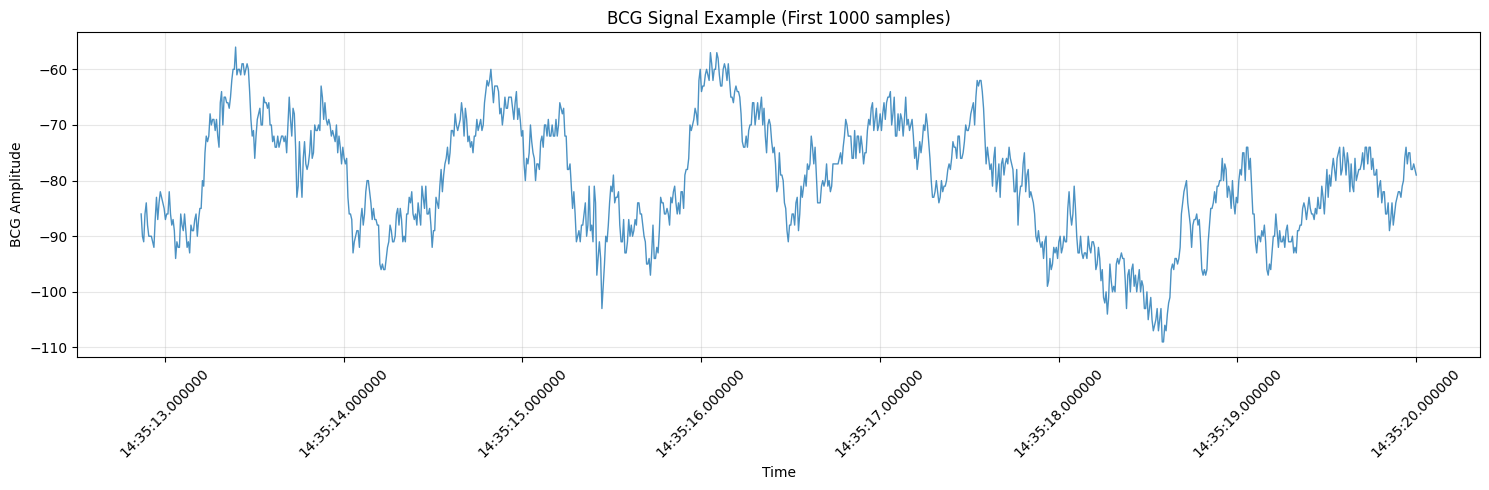

In [25]:
def plot_bcg_signal(data_dict, title="BCG Signal", samples_to_plot=1000):
    """Plot a segment of BCG data with proper timestamps"""
    plt.figure(figsize=(15, 5))

    # Extract the DataFrame from the dictionary
    df = data_dict['bcg_data']

    # Plot first n samples
    plot_df = df.head(samples_to_plot)

    plt.plot(plot_df['Datetime'], plot_df['BCG'],
             linewidth=1, alpha=0.8)

    # Format x-axis
    ax = plt.gca()
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S.%f'))
    plt.xticks(rotation=45)

    plt.title(f"{title} (First {samples_to_plot} samples)")
    plt.ylabel("BCG Amplitude")
    plt.xlabel("Time")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# %%
# Plot first file as example
if all_bcg_data_with_ref:
    first_file_data = next(iter(all_bcg_data_with_ref.values()))
    print("BCG Data Columns:", first_file_data['bcg_data'].columns)
    # Now available
    print("RR Data Columns:", first_file_data['rr_data'].columns)
    plot_bcg_signal(first_file_data, title="BCG Signal Example",
                    samples_to_plot=1000)

## 4. Synchronize Data

In [26]:
def check_time_alignment(bcg_data, rr_data):
    """Verify if BCG and RR data overlap in time"""
    bcg_start = bcg_data['Datetime'].min()
    bcg_end = bcg_data['Datetime'].max()
    rr_start = rr_data['Datetime'].min()
    rr_end = rr_data['Datetime'].max()
    
    print(f"BCG Range: {bcg_start} to {bcg_end}")
    print(f"RR Range:  {rr_start} to {rr_end}")
    
    if rr_start > bcg_end or rr_end < bcg_start:
        print("Warning: No temporal overlap between BCG and RR data!")
        return False
    return True

In [27]:
def synchronize_data(bcg_data, rr_data):
    """Align BCG and RR data based on timestamps"""
    # Convert to pandas DateTimeIndex for both datasets
    bcg_times = pd.DatetimeIndex(bcg_data['Datetime'])
    rr_times = pd.DatetimeIndex(rr_data['Datetime'])
    
    # Find overlapping period
    start_time = max(bcg_times.min(), rr_times.min())
    end_time = min(bcg_times.max(), rr_times.max())
    
    # Filter both datasets to overlapping period
    bcg_sync = bcg_data[bcg_data['Datetime'].between(start_time, end_time)]
    rr_sync = rr_data[rr_data['Datetime'].between(start_time, end_time)]
    
    return {
        'bcg': bcg_sync,
        'rr': rr_sync,
        'start_time': start_time,
        'end_time': end_time
    }

In [28]:
# After loading data, for each subject:
for bcg_path, data in all_bcg_data_with_ref.items():
    bcg_df = data['bcg_data']
    rr_df = data['rr_data']
    
    # Check alignment first
    if not check_time_alignment(bcg_df, rr_df):
        continue
    
    # Synchronize data
    synchronized = synchronize_data(bcg_df, rr_df)
    
    # Update the dictionary with synchronized data
    all_bcg_data_with_ref[bcg_path]['sync_data'] = synchronized

BCG Range: 2023-11-03 14:35:12.866000 to 2023-11-03 21:48:54.344571533
RR Range:  2023-03-11 22:39:15 to 2023-04-11 05:45:52
BCG Range: 2023-11-04 11:17:35.239000 to 2023-11-04 22:05:51.624714355
RR Range:  2023-04-11 19:12:20 to 2023-05-11 06:01:22
BCG Range: 2023-11-02 15:12:32.363000 to 2023-11-03 00:13:22.763000
RR Range:  2023-02-11 23:13:17 to 2023-03-11 08:11:23
BCG Range: 2023-11-03 15:34:23.797000 to 2023-11-03 23:56:26.447000
RR Range:  2023-03-11 23:31:41 to 2023-04-11 07:54:04
BCG Range: 2023-11-02 17:20:33.341000 to 2023-11-03 00:00:02.383857178
RR Range:  2023-03-11 01:17:32 to 2023-03-11 07:55:27
BCG Range: 2023-11-04 15:47:49.870000 to 2023-11-05 01:30:00.655714355
RR Range:  2023-05-11 00:03:48 to 2023-05-11 09:29:33
BCG Range: 2023-11-02 15:18:01.526000 to 2023-11-03 00:31:55.840285645
RR Range:  2023-02-11 23:24:10 to 2023-03-11 09:04:49
BCG Range: 2023-11-03 16:31:18.114000 to 2023-11-04 01:35:14.985428467
RR Range:  2023-04-11 00:17:13 to 2023-04-11 10:25:09
BCG Ra